In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
data = pd.read_csv('a2_data/housepricedata.csv')

In [69]:
x = data.drop('AboveMedianPrice',axis = 1)
y = data['AboveMedianPrice']
X = np.array(x)
y = np.array(y)

X = (X-np.mean(X, axis = 0))/np.std(X,axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [103]:
nn_layers = [
    {"layer": "1", "in_dim": 10, "out_dim": 5},
    {"layer": "2", "in_dim": 5, "out_dim": 3},
    {"layer": "3", "in_dim": 3, "out_dim": 3},
    {"layer": "4", "in_dim": 3, "out_dim": 2},
    {"layer": "final", "in_dim": 5, "out_dim": 1},
]

In [117]:
def init_layer(nn_layers, num_layers, seed):
    np.random.seed(seed)
    parameters = {}
    
    for i in range(num_layers):
        layer_output_size = nn_layers[i]["out_dim"]
        layer_input_size = nn_layers[i]["in_dim"]
        parameters['W' + nn_layers[i]["layer"]] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        parameters['b' + nn_layers[i]["layer"]] = np.random.randn(
            layer_output_size, 1) * 0.1
    parameters['W' + nn_layers[4]["layer"]] = np.random.randn(1,nn_layers[num_layers-1]["out_dim"]) * 0.1
    parameters['b' + nn_layers[4]["layer"]] = np.random.randn(1, 1) * 0.1
    return parameters

In [118]:
#Sigmoid Activation
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

In [119]:
#relU Activation
def relu(Z):
    return np.maximum(0,Z)

In [120]:
#tanh Activation
def tanh(Z):
    return np.tanh(Z)

In [121]:
def forward_propagate(parameters, x, nn_layers, num_layers, activation):
    layer_data = {}
    a = x.T
    a_prev = a
    j = 0;
    for i in range(len(nn_layers)):
        if (i < num_layers or nn_layers[i]["layer"] == "final"):
            W = parameters['W' + nn_layers[i]["layer"]]
            b = parameters['b' + nn_layers[i]["layer"]]
            a_prev = a

            z = np.dot(W, a_prev) + b
            if activation[j] == "sigmoid":
                a = sigmoid(z)
            elif activation[j] == "relu":
                a = relu(z)
            elif activation[j] == "tanh":
                a = tanh(z)
            layer_data["a_prev"+ str(j)] = a_prev
            layer_data['z'+ str(j+1)] = z
            layer_data['a'+ str(j+1)] = a
            layer_data['W' + str(j+1)] = W
            layer_data['b' + str(j+1)] = b
            j = j+1
    
    return a, layer_data

In [122]:
def cross_entropy_loss(y_pred, y):
    cost = -1 * (np.dot(y, np.log(y_pred).T) + np.dot(1 - y, np.log(1 - y_pred).T))
    return np.squeeze(cost)

In [123]:
def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

In [124]:
def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

In [125]:
def tanh_backward(dA, Z):
    t = tanh(Z)
    return dA*(1-np.square(t))

In [126]:
def back_propagate(parameters, y, y_pred, nn_layers, num_layers, activation, layer_data):
    y = y.reshape(y_pred.shape)
    dA_prev = - (np.divide(y, y_pred) - np.divide(1 - y, 1 - y_pred));
    
#     print(layer_data)
    for i in reversed(range(num_layers+1)):
        dA = dA_prev
        a_prev = layer_data["a_prev" + str(i)]
        z = layer_data["z" + str(i+1)]
        W = layer_data["W" + str(i+1)]
        b = layer_data["b" + str(i+1)]
        
        if activation[i] == "sigmoid":
                dZ = sigmoid_backward(dA, z)
        elif activation[i] == "relu":
                dZ = relu_backward(dA, z)
        elif activation[i] == "tanh":
                dZ = tanh_backward(dA, z)
        
        dW = np.dot(dZ, a_prev.T) / a_prev.shape[1]
        db = np.sum(dZ, axis=1, keepdims=True) / a_prev.shape[1]
        dA_prev = np.dot(W.T, dZ)
        
        layer_data["dW" + str(i+1)] = dW
        layer_data["db" + str(i+1)] = db
    
    return layer_data
        
        
            

In [144]:
def accuracy_func(y_pred, y):
    y_new = np.copy(y_pred)
    y_new[y_new > 0.5] = 1
    y_new[y_new <= 0.5] = 0
    return (y_new == y).all(axis=0).mean()

In [175]:
def F_score(y_pred, y):
    fp,fn,tp,tn = [0,0,0,0]
    y_new = np.copy(y_pred).reshape((Y_test_hat.shape[1], ))
    y_new[y_new > 0.5] = 1
    y_new[y_new <= 0.5] = 0
    for i in range(len(y_new)):
        if(y[i] == 1):
            if (y_new[i] == 1):
                tp+=1
            else:
                fn+=1
        else:
            if(y_new[i] == 0):
                tn+=1
            else:
                fp+=1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = (2 * precision * recall) / (precision + recall)
    return f_score

In [142]:
def train(x, y, nn_layers, learning_rate, epoch, activation, num_layers):
    parameters = init_layer(nn_layers, num_layers, 123)
    loss_val = []
    acc_val = []
    
    for i in range(epoch):
        y_pred, layer_data = forward_propagate(parameters, x, nn_layers, num_layers, activation)
        
        loss = cross_entropy_loss(y_pred, y)
        loss_val.append(loss)
        
        accuracy = accuracy_func(y_pred, y)
        acc_val.append(accuracy)
        
        new_layer_data = back_propagate(parameters, y, y_pred, nn_layers, num_layers, activation, layer_data)

        k = 0
        for j in range(len(nn_layers)):
            if j < num_layers or nn_layers[j]["layer"] == "final":
                parameters['W' + nn_layers[j]["layer"]] -= learning_rate * new_layer_data["dW" + str(k+1)]        
                parameters["b" + nn_layers[j]["layer"]] -= learning_rate * new_layer_data["db" + str(k+1)]
                k += 1
    return parameters, loss_val, acc_val

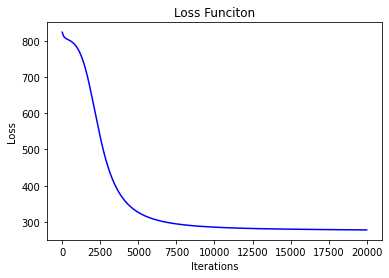

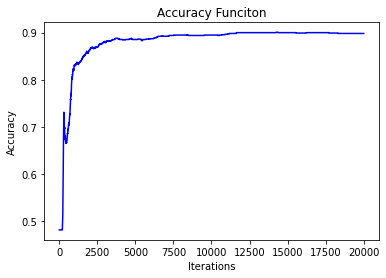

Test set accuracy: 0.91
Test set F score: 0.92


In [177]:
## Hidden layers: 1, Activations: Sigmoid, Sigmoid
activation = ["sigmoid", "sigmoid"]
parameters, loss_val, acc_val = train(X_train, y_train, nn_layers, 0.01, 20000, activation, 1)

## Loss Values plot
plt.plot(loss_val, 'b')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Funciton')
plt.show()

## Accuracy Plot
plt.plot(acc_val, 'b')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Funciton')
plt.show()

# Prediction
y_pred, _ = forward_propagate(parameters, X_test, nn_layers, 1, activation)

## Test Accuracy
acc_test = accuracy_func(y_pred, y_test)
print("Test set accuracy: {:.2f}".format(acc_test))
fscore = F_score(y_pred, y_test)
print("Test set F score: {:.2f}".format(fscore))

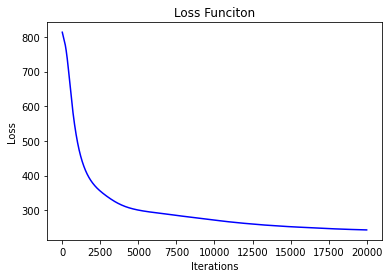

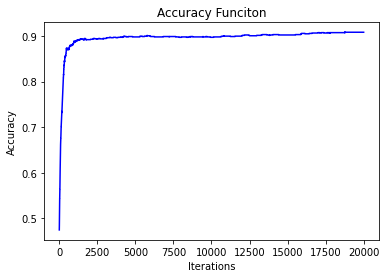

Test set accuracy: 0.91
Test set F score: 0.92


In [176]:
## Hidden layers: 1, Activations: Relu, Sigmoid
activation = ["relu", "sigmoid"]
parameters, loss_val, acc_val = train(X_train, y_train, nn_layers, 0.01, 20000, activation, 1)

## Loss Values plot
plt.plot(loss_val, 'b')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Funciton')
plt.show()

## Accuracy Plot
plt.plot(acc_val, 'b')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Funciton')
plt.show()

# Prediction
y_pred, _ = forward_propagate(parameters, X_test, nn_layers, 1, activation)

## Test Accuracy
acc_test = accuracy_func(y_pred, y_test)
print("Test set accuracy: {:.2f}".format(acc_test))
fscore = F_score(y_pred, y_test)
print("Test set F score: {:.2f}".format(fscore))

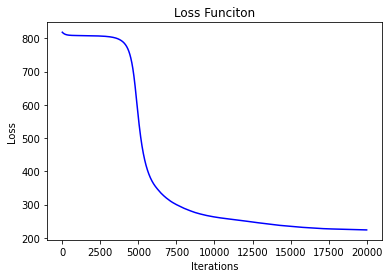

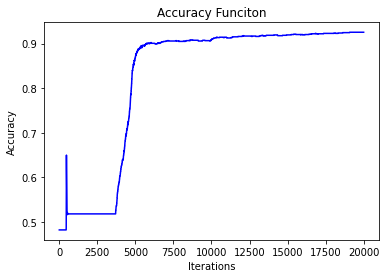

Test set accuracy: 0.90
Test set F score: 0.91


In [178]:
## Hidden layers: 3, Activations: Relu, tanh, relu, Sigmoid
activation = ["relu", "tanh", "relu", "sigmoid"]
parameters, loss_val, acc_val = train(X_train, y_train, nn_layers, 0.01, 20000, activation, 3)

plt.plot(loss_val, 'b')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Funciton')
plt.show()

plt.plot(acc_val, 'b')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Funciton')
plt.show()

# Prediction
y_pred, _ = forward_propagate(parameters, X_test, nn_layers, 3, activation)

## Test Accuracy
acc_test = accuracy_func(y_pred, y_test)
print("Test set accuracy: {:.2f}".format(acc_test))
fscore = F_score(y_pred, y_test)
print("Test set F score: {:.2f}".format(fscore))

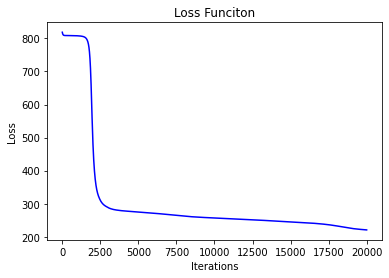

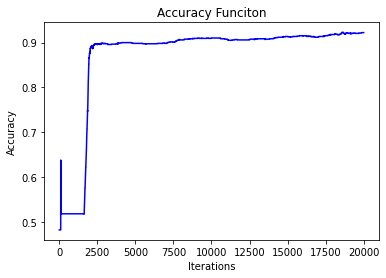

Test set accuracy: 0.91
Test set F score: 0.92


In [179]:
## Hidden layers: 3, Activations: relu, sigmoid, relu, Sigmoid
activation = ["sigmoid", "tanh", "relu", "sigmoid"]
parameters, loss_val, acc_val = train(X_train, y_train, nn_layers, 0.05, 20000, activation, 3)

plt.plot(loss_val, 'b')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Funciton')
plt.show()

plt.plot(acc_val, 'b')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Funciton')
plt.show()

# Prediction
y_pred, _ = forward_propagate(parameters, X_test, nn_layers, 3, activation)

## Test Accuracy
acc_test = accuracy_func(y_pred, y_test)
print("Test set accuracy: {:.2f}".format(acc_test))
fscore = F_score(y_pred, y_test)
print("Test set F score: {:.2f}".format(fscore))

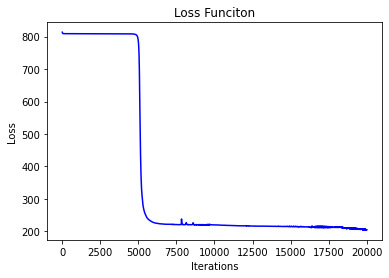

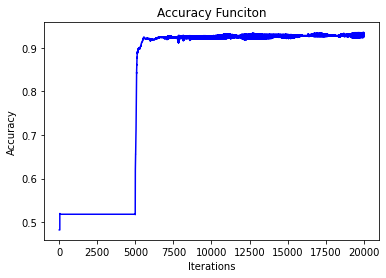

Test set accuracy: 0.91
Test set F score: 0.92


In [180]:
## Hidden layers: 4, Activations: Relu, relu, tanh, relu, Sigmoid
activation = ["relu", "relu", "tanh", "relu", "sigmoid"]
parameters, loss_val, acc_val = train(X_train, y_train, nn_layers, 0.1, 20000, activation, 4)

plt.plot(loss_val, 'b')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Funciton')
plt.show()

plt.plot(acc_val, 'b')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Funciton')
plt.show()

# Prediction
y_pred, _ = forward_propagate(parameters, X_test, nn_layers, 4, activation)

## Test Accuracy
acc_test = accuracy_func(y_pred, y_test)
print("Test set accuracy: {:.2f}".format(acc_test))
fscore = F_score(y_pred, y_test)
print("Test set F score: {:.2f}".format(fscore))